# Task Description
Build end-to-end boosting pipeline with feature selection and model evaluation on a dataset with very imbalanced classes.  

Train the model on objects with OBSDATE < 2023-11-01, test on objects with OBSDATE >= 2023-11-01.


# Initial Setup

In [85]:
import pandas as pd
import numpy as np
import category_encoders as ce # https://contrib.scikit-learn.org/category_encoders/
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [2]:
df = pd.read_parquet("initial_data/MIPT_data_prod.parquet")
df

,TARGET,OBSDATE,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_226,col_227,col_228,col_229,col_230,col_231,col_232,col_233,col_234,client_id
464723,0,2023-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1499.0,4.0,NaN,0.0,NaN,-1.0,NaN,NaN,5.75,386309
706874,0,2023-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1591.0,4.0,NaN,0.0,NaN,5.0,NaN,NaN,5.65,2066415
139927,0,2023-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.00,NaN,NaN,0.0,5.50,2333418
267979,0,2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.75,1054377
479451,0,2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,-1.0,NaN,NaN,5.75,2012844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135780,0,2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1664.0,4.0,NaN,0.0,2.04,1.0,NaN,NaN,5.90,133270
693921,0,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1834.0,4.5,NaN,0.0,NaN,NaN,NaN,NaN,5.75,1793861
171498,0,2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4497.0,5.0,NaN,0.0,NaN,106547.0,NaN,NaN,5.90,1821283
751597,0,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1998.0,5.0,NaN,0.0,NaN,1.0,NaN,NaN,5.90,915641


In [3]:
# Dropping 'client_id' column
df.drop(columns=['client_id'], inplace=True)

In [4]:
# Dropping columns with more than 80% of NaNs
print(f"Original shape: {df.shape}")
columns_to_delete = df.isna().sum() > (0.8 * len(df))
columns_to_delete = columns_to_delete[columns_to_delete == True].index
print(f"{len(columns_to_delete)} columns contain more than 80% of NaNs, they will be deleted.")
df.drop(columns=columns_to_delete, inplace=True)
print(f"New shape: {df.shape}")

Original shape: (100000, 237)
43 columns contain more than 80% of NaNs, they will be deleted.
New shape: (100000, 194)


In [5]:
# Dropping constant columns
distinct_values = pd.DataFrame()
for column in df.columns:
    distinct_values = pd.concat([distinct_values, pd.DataFrame(data={'column': [column],
                       'num_distinct_values': [len(df.value_counts(column, dropna=True))]})])
columns_to_delete = distinct_values[distinct_values['num_distinct_values'] == 1]['column'].values
print(f"Columns that contain only one distinct value: {columns_to_delete}")
print("They will be deleted.")
df.drop(columns=columns_to_delete, inplace=True)
print(f"New shape: {df.shape}")

Columns that contain only one distinct value: ['col_46' 'col_51' 'col_56' 'col_61' 'col_66' 'col_71' 'col_76']
They will be deleted.
New shape: (100000, 187)


We need to identify categorical and numerical features.  
Let us have a look at the number of distinct values for it.

In [6]:
# Getting the number of distinct values in each column
distinct_values = distinct_values[distinct_values['num_distinct_values'] != 1]
distinct_values.sort_values(by='num_distinct_values', inplace=True)
distinct_values = (distinct_values[(distinct_values['column'] != 'TARGET') & (distinct_values['column'] != 'OBSDATE')]).reset_index(drop=True)
distinct_values

,column,num_distinct_values
0,col_179,2
1,col_164,2
2,col_163,2
3,col_162,2
4,col_161,2
...,...,...
180,col_116,62881
181,col_220,66039
182,col_108,75152
183,col_96,76816


Now we that have the number of distinct values in each column, we need to try to identify categorical features among them.  
First of all, let us limit ourselves to columns that have no more than 20 distinct values.

In [7]:
categorical_features = distinct_values[distinct_values['num_distinct_values'] <= 20]
categorical_features

,column,num_distinct_values
0,col_179,2
1,col_164,2
2,col_163,2
3,col_162,2
4,col_161,2
...,...,...
67,col_70,18
68,col_189,18
69,col_142,19
70,col_181,19


It is obvious that columns which have only two distinct values are categorical, but what to do with the others?  
Most likely, categorical features were label-encoded, so they contain only consecutive non-negative integer numbers. Let us identify them.

In [8]:
categorical_features['values'] = np.nan
categorical_features['values'] = categorical_features['values'].astype('object')

for column in categorical_features['column'].values:
    values = sorted(df[df[column].notna()][column].unique())
    
    nonnegative = values[0] >= 0
    consecutive = all(values[i] + 1 == values[i + 1] for i in range(len(values) - 1))
    if consecutive and nonnegative:    
        index = categorical_features[categorical_features['column'] == column].index[0]
        categorical_features.at[index, 'values'] = values
        
categorical_features = categorical_features[categorical_features['values'].notna()].reset_index(drop=True)

In [9]:
categorical_features

,column,num_distinct_values,values
0,col_179,2,"[0, 1]"
1,col_164,2,"[0, 1]"
2,col_163,2,"[0, 1]"
3,col_162,2,"[0, 1]"
4,col_161,2,"[0, 1]"
5,col_160,2,"[0, 1]"
6,col_159,2,"[0, 1]"
7,col_80,2,"[0, 1]"
8,col_158,2,"[0, 1]"
9,col_156,2,"[0, 1]"


Theoretically, columns col_202, col_86, col_201 and col_200 can be categorical, but I cannot be sure, so let us consider them numerical for simplicity.  
Below there is a final list with categorical features.

In [10]:
categorical_features = categorical_features[categorical_features['num_distinct_values'] <= 5]
categorical_features = list(categorical_features['column'].values)
categorical_features

['col_179',
 'col_164',
 'col_163',
 'col_162',
 'col_161',
 'col_160',
 'col_159',
 'col_80',
 'col_158',
 'col_156',
 'col_155',
 'col_154',
 'col_84',
 'col_83',
 'col_82',
 'col_81',
 'col_157',
 'col_30',
 'col_79',
 'col_18',
 'col_16',
 'col_17',
 'col_29',
 'col_19',
 'col_20',
 'col_21',
 'col_14',
 'col_22',
 'col_24',
 'col_25',
 'col_26',
 'col_27',
 'col_28',
 'col_13',
 'col_23',
 'col_15',
 'col_199',
 'col_195']

In [11]:
numerical_features = list(set(df.columns) - set(categorical_features) - {'OBSDATE', 'TARGET'})
numerical_features

['col_32',
 'col_185',
 'col_234',
 'col_216',
 'col_200',
 'col_191',
 'col_98',
 'col_205',
 'col_39',
 'col_59',
 'col_111',
 'col_38',
 'col_227',
 'col_119',
 'col_181',
 'col_198',
 'col_128',
 'col_87',
 'col_75',
 'col_127',
 'col_88',
 'col_86',
 'col_208',
 'col_193',
 'col_60',
 'col_122',
 'col_130',
 'col_67',
 'col_189',
 'col_136',
 'col_125',
 'col_150',
 'col_182',
 'col_192',
 'col_126',
 'col_224',
 'col_212',
 'col_34',
 'col_188',
 'col_135',
 'col_58',
 'col_70',
 'col_124',
 'col_117',
 'col_49',
 'col_207',
 'col_77',
 'col_121',
 'col_184',
 'col_142',
 'col_106',
 'col_213',
 'col_64',
 'col_97',
 'col_36',
 'col_53',
 'col_201',
 'col_197',
 'col_223',
 'col_57',
 'col_141',
 'col_37',
 'col_110',
 'col_196',
 'col_114',
 'col_229',
 'col_91',
 'col_214',
 'col_194',
 'col_226',
 'col_105',
 'col_31',
 'col_41',
 'col_137',
 'col_220',
 'col_211',
 'col_203',
 'col_42',
 'col_180',
 'col_118',
 'col_183',
 'col_35',
 'col_209',
 'col_109',
 'col_129',
 'col_1

In [12]:
# Checking
print(f"Total number of features: {df.shape[1]}")
print(f"Number of categorical features: {len(categorical_features)}")
print(f"Number of numerical features: {len(numerical_features)}")

Total number of features: 187
Number of categorical features: 38
Number of numerical features: 147


Theoretically, we could use some ML algorithm to predict missing values, but it is too time-consuming and may not improve our metrics at all. Let us fill gaps with modes and medians instead.

According to the task, we need to predict target values for objects where OBSDATE >= "2023-11-01", but to train our model on the part where OBSDATE < "2023-11-01".  
This means, we should keep in mind that at the moment of training, values with OBSDATE >= "2023-11-01" are unknown yet. Thus, we need to calculate modes and medians only based on the train part (OBSDATE < "2023-11-01").  
Simply doing this would be incorrect:
```
df[categorical_features] = df[categorical_features].apply(lambda x: x.fillna(x.mode()[0]), axis=0)
df[numerical_features] = df[numerical_features].apply(lambda x: x.fillna(x.median()), axis=0)
```

In [13]:
# Filling NaNs in categorical and numerical columns with the corresponding modes and medians respectively
def fillna_mode_median(df):
    for column in df.columns:
        df_test = df[df['OBSDATE'] < "2023-11-01"]
        if column in categorical_features:
            df[column].fillna(value=df_test[column].mode()[0], inplace=True)
        elif column in numerical_features:
            df[column].fillna(value=df_test[column].median(), inplace=True)
        
fillna_mode_median(df)

In [14]:
print(f"The remaining number of NaNs in the dataframe: {df.isna().sum().values.sum()}")

The remaining number of NaNs in the dataframe: 0


I am to target encode categorical features using cat_boost.CatBoostEncoder() from category_encoders library.

In [15]:
X_train = df[df['OBSDATE'] < "2023-11-01"].drop('TARGET', axis = 1)
y_train = df[df['OBSDATE'] < "2023-11-01"]['TARGET']

X_test = df[df['OBSDATE'] >= "2023-11-01"].drop('TARGET', axis = 1)
y_test = df[df['OBSDATE'] >= "2023-11-01"]['TARGET']

In [16]:
# https://contrib.scikit-learn.org/category_encoders/catboost.html#category_encoders.cat_boost.CatBoostEncoder.fit
# https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/?ysclid=m80nfid2rh285994528
encoder = ce.CatBoostEncoder(cols=categorical_features, random_state=42, verbose=1)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train, y_train) 
X_test_encoded = encoder.transform(X_test) 

In [17]:
X_train_encoded.drop('OBSDATE', axis=1, inplace=True)
X_test_encoded.drop('OBSDATE', axis=1, inplace=True)

# Dataset Splitting

In [18]:
X_train_encoded, X_val_encoded, y_train, y_val = train_test_split(X_train_encoded, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [19]:
# Checking shapes
print(f"Train: {X_train_encoded.shape}, {y_train.shape}")
print(f"Val: {X_val_encoded.shape}, {y_val.shape}")
print(f"Test: {X_test_encoded.shape}, {y_test.shape}")

Train: (52103, 185), (52103,)
Val: (13026, 185), (13026,)
Test: (34871, 185), (34871,)


In [20]:
# Checking class proportions
print('y_train:')
display(y_train.value_counts(normalize=True) * 100)
print('-' * 20)
print('y_val:')
display(y_val.value_counts(normalize=True) * 100)
print('-' * 20)
print('y_test:')
display(y_test.value_counts(normalize=True) * 100)

y_train:


TARGET
0    98.109514
1     1.890486
Name: proportion, dtype: float64

--------------------
y_val:


TARGET
0    98.111469
1     1.888531
Name: proportion, dtype: float64

--------------------
y_test:


TARGET
0    98.996301
1     1.003699
Name: proportion, dtype: float64

# Oversampling

Addressing class imbalance by ADASYN from imblearn.over_sampling.

In [21]:
adasyn = ADASYN()

In [22]:
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_encoded, y_train)

In [23]:
print(y_train_adasyn.value_counts(normalize=True) * 100)
print('-' * 20)
print(f"New train shapes: {X_train_adasyn.shape}, {y_train_adasyn.shape}")

TARGET
0    50.137314
1    49.862686
Name: proportion, dtype: float64
--------------------
New train shapes: (101956, 185), (101956,)


# Feature Selection

I am going to try several approaches to feature selection in order to reduce matrix dimension.   
First, let us normalise numerical features just in case.

In [24]:
scaler = RobustScaler()

X_train_adasyn[numerical_features] = scaler.fit_transform(X_train_adasyn[numerical_features])
X_val_encoded[numerical_features] = scaler.transform(X_val_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

Now, let us identify features that have too high correlation with the target variable.

In [25]:
corr_train_adasyn_with_y = X_train_adasyn.corrwith(y_train_adasyn)
print(f"Correlation of features in X_train_adasyn with target (after target encoding and ADASYN):")
print(corr_train_adasyn_with_y.abs().sort_values(ascending=False)[:5])

Correlation of features in X_train_adasyn with target (after target encoding and ADASYN):
col_234    0.974791
col_205    0.313199
col_153    0.161446
col_80     0.156237
col_150    0.151104
dtype: float64


col_234 values almost entirely correspond to target on the train dataset after target encoding. What about the test dataset?

In [26]:
corr_test_with_y = X_test.corrwith(y_test)
print(f"Correlation of features in X_test with target:")
print(corr_test_with_y.abs().sort_values(ascending=False)[:5])

Correlation of features in X_test with target:
col_234    0.660844
col_205    0.084593
col_137    0.064895
col_164    0.046574
col_132    0.043860
dtype: float64


On the test dataset, the correlation between col_234 and target is significantly weaker, but it is still considerable.  
Let us follow the entire transformation path and check if before target encoding or applying ADASYN, values differed. Significant difference could mean data leakage.

In [27]:
corr_train_encoded_with_y = X_train_encoded.corrwith(y_train)
print(f"Correlation of features in X_train_encoded with target (after tagret encoding):")
print(corr_train_encoded_with_y.abs().sort_values(ascending=False)[:5])

Correlation of features in X_train_encoded with target (after tagret encoding):
col_234    0.763575
col_205    0.090622
col_137    0.065631
col_112    0.055036
col_80     0.053242
dtype: float64


In [28]:
corr_train_with_y = X_train.corrwith(y_train)
print(f"Correlation of features in X_train with target (before any processing):")
print(corr_train_with_y.abs().sort_values(ascending=False)[:5])

Correlation of features in X_train with target (before any processing):
col_234    0.763575
col_205    0.090622
col_137    0.065631
OBSDATE    0.062927
col_80     0.055807
dtype: float64


As we can see, the correlation between col_234 and target was high even before any processing. It was not affected by target encoding anyhow, but has grown even higher after ADASYN application.  
If we leave this column as it is, the algorithm will identify the correspondence between the two values and will predict labels with high accuracy based on it. Meanwhile, on test dataset, it will perform much worse, given that the correlation there is significantly lower.  
It is a good idea to drop this column.

In [29]:
X_train_adasyn.drop(columns='col_234', inplace=True)
X_val_encoded.drop(columns='col_234', inplace=True)
X_test_encoded.drop(columns='col_234', inplace=True)

if 'col_234' in numerical_features:
    numerical_features.remove('col_234')

Now, let us see what features are multicolinear (have correlation > 0.9).

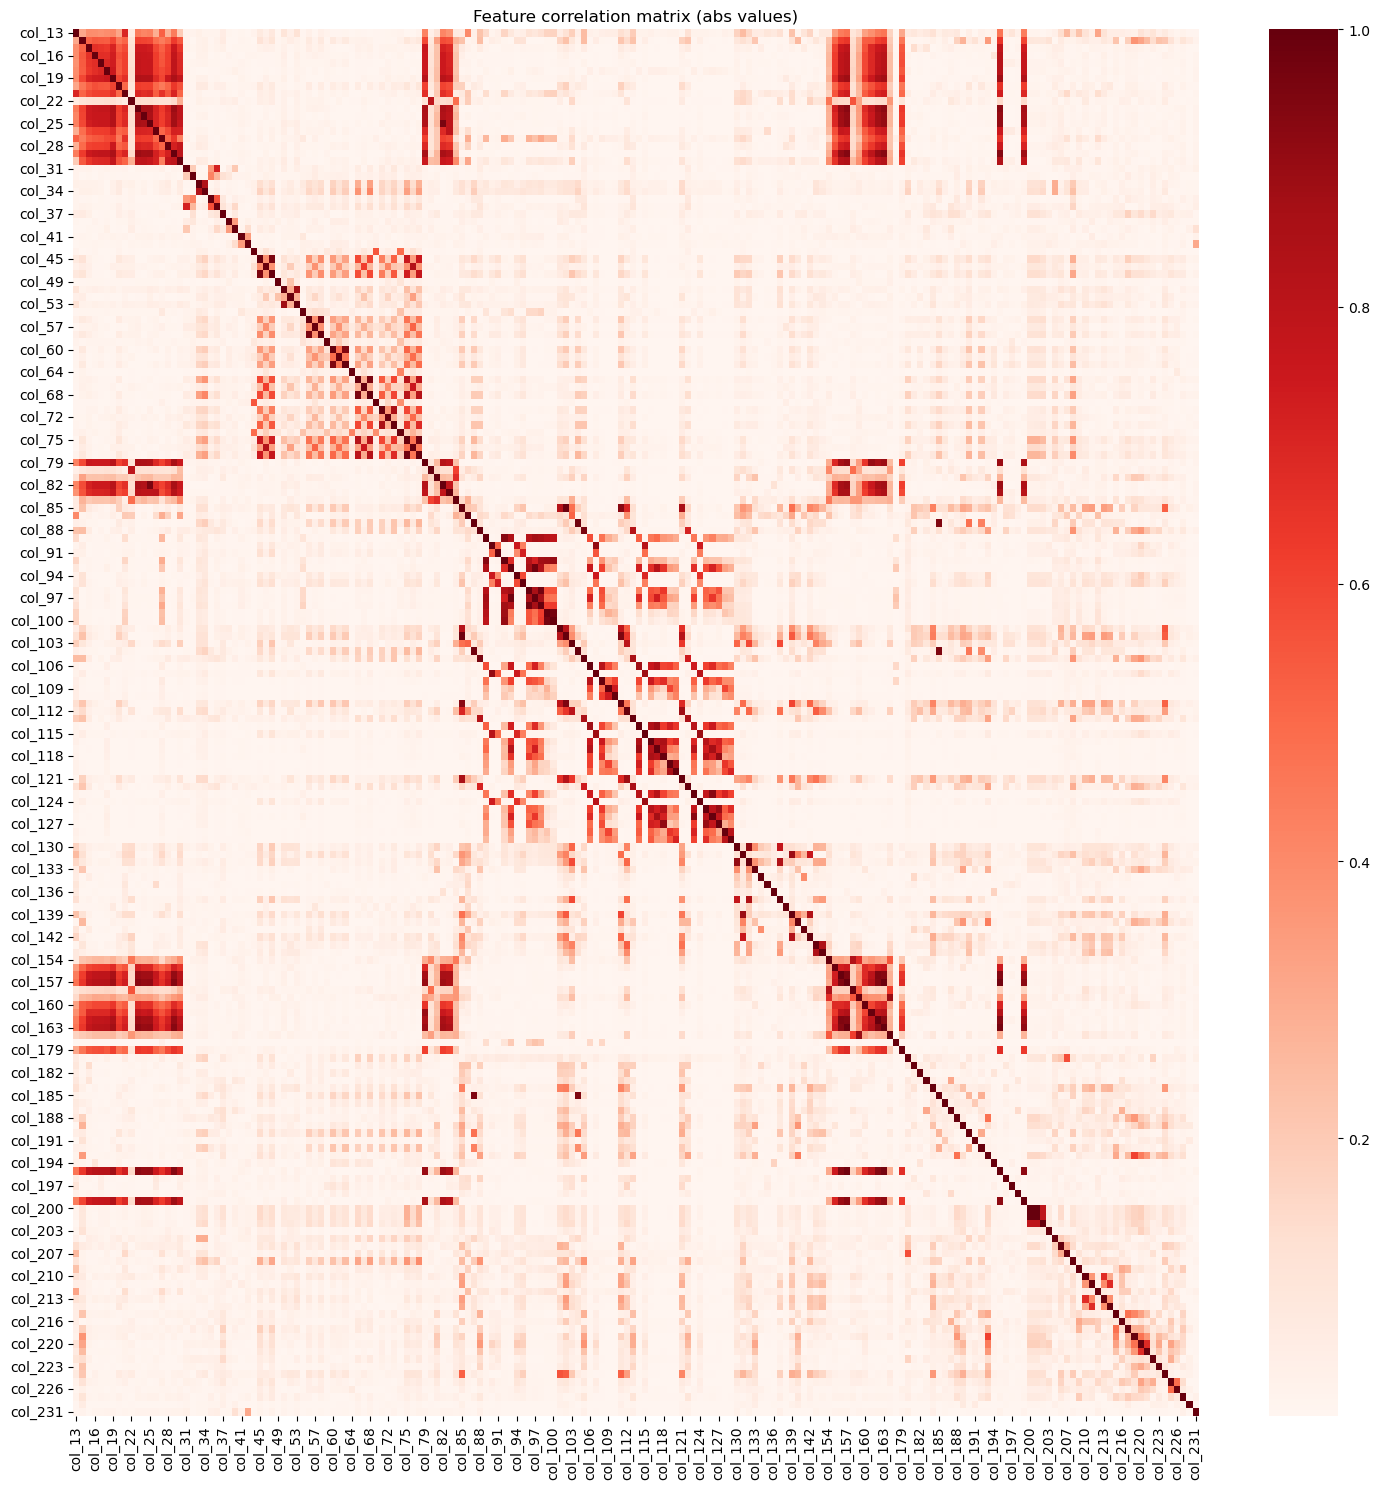

In [30]:
multicorr_matrix = X_train_adasyn.corr().abs()

plt.figure(figsize=(15, 15))
sns.heatmap(multicorr_matrix, annot=False, cmap="Reds")
plt.title("Feature correlation matrix (abs values)")
plt.tight_layout()
plt.show()

In [31]:
for i in range(len(multicorr_matrix)):
    multicorr_matrix.iloc[i, i] = 0

def corr_more_0_9(line):
    line = line.sort_values(ascending=False)
    corr_with = line[line > 0.9].index
    return list(corr_with) if len(corr_with) > 0 else np.nan

multicorr_more_0_9 = pd.DataFrame(multicorr_matrix.apply(corr_more_0_9, axis=1), columns=['corr_with'])
multicorr_more_0_9 = multicorr_more_0_9[multicorr_more_0_9['corr_with'].notna()]
multicorr_more_0_9['num_corr'] = multicorr_more_0_9['corr_with'].apply(lambda x: len(x))
multicorr_more_0_9 = multicorr_more_0_9.sort_values('num_corr', ascending=False)
multicorr_more_0_9

,corr_with,num_corr
col_157,"[col_163, col_195, col_156, col_29, col_162, c...",10
col_195,"[col_157, col_163, col_156, col_29, col_162, c...",9
col_163,"[col_157, col_195, col_156, col_162, col_29, c...",9
col_29,"[col_157, col_195, col_163, col_156, col_162]",5
col_162,"[col_156, col_157, col_195, col_163, col_29]",5
col_156,"[col_162, col_157, col_195, col_163, col_29]",5
col_25,"[col_82, col_157, col_195, col_163]",4
col_23,"[col_157, col_195, col_163]",3
col_199,"[col_157, col_195, col_163]",3
col_24,"[col_157, col_195, col_163]",3


Keeping all of them does not make much sense, we need to identify which are most important.

I am going to try several approaches to feature selection on CatBoostClassifier and XGBClassifier:  
1. In-built methods: get_feature_importance() for CatBoost and get_score() for XGBoost
2. Manual removal of multicollinear features followed by in-built methods
3. Permutation_importance

In [32]:
# In-built feature importance for CatBoost
def get_feature_importance_catboost(param_dict, 
                                    X_train, 
                                    y_train,
                                    X_val,
                                    y_val):
    '''
    The function takes a dictionary with parameters, instantiates and fits CatBoostClassifier, 
    computes feature importance and returns it in the form of a dataframe.
    '''
    param_dict.pop('eval_metric', None)
    
    # Creating a Pool object for the training and testing data
    train_pool = Pool(X_train, label=y_train)
    test_pool = Pool(X_val, label=y_val)

    # Training model with certain params
    model = CatBoostClassifier(**param_dict, random_state=42)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
    
    # Obtaining feature importance
    feature_importance = model.get_feature_importance()
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df.sort_values(by="Importance", ascending=False, inplace=True)

    return importance_df

In [33]:
# In-built feature importance for XGBoost 
# https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
def get_feature_importance_xgboost(param_dict, 
                                   X_train, 
                                   y_train,
                                   X_val,
                                   y_val):
    '''
    The function takes a dictionary with parameters, instantiates and fits XGBClassifier, 
    computes feature importance and returns it in the form of a dataframe.
    '''
    # Training model with certain params
    model = xgb.XGBClassifier(**param_dict, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Obtaining feature importance
    feature_importance = model.get_booster().get_score(importance_type='weight')

    feature_importance = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
    feature_importance.reset_index(drop=True, inplace=True)
    return feature_importance

In [34]:
def select_k_features(importance_df, 
                      k, 
                      X_train=X_train_adasyn, 
                      y_train=y_train_adasyn, 
                      X_val=X_val_encoded,
                      y_val=y_val,
                      X_test=X_test_encoded,
                      y_test=y_test):
    '''
    This function selects k most important features from the importance_df and returns new train, val and test dataframes.
    '''
    k_features = list(importance_df[:k]['Feature'])
    X_train_k = X_train[k_features]
    y_train_k = y_train
    X_val_k = X_val[k_features]
    y_val_k = y_val
    X_test_k = X_test[k_features]
    y_test_k = y_test
    return X_train_k, y_train_k, X_val_k, y_val_k, X_test_k, y_test_k

In [35]:
# https://www.geeksforgeeks.org/catboost-metrics-for-model-evaluation/
def fit_predict_val_catboost_xgboost(param_dict, 
                                    classifier,
                                    X_train_k, 
                                    y_train_k, 
                                    X_val_k, 
                                    y_val_k):
    '''
    A function that instantiates CatBoost or XGBClassifier with a passed param_dict, trains and validates on passed data 
    and returns a dataframe with metrics.
    '''
    if classifier == 'CatBoostClassifier':
        model = CatBoostClassifier(**param_dict, random_state=42)
    
        # Creating a Pool object for the training and testing data
        train_pool = Pool(X_train_k, label=y_train_k)
        test_pool = Pool(X_val_k, label=y_val_k)
    
        # Training the model
        # model.fit(train_pool) 
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
        
        '''
        # Evaluating the model using CatBoost metrics
        metrics_dict = model.eval_metrics(test_pool, 
                                         metrics=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
        metrics = {}
        for key in metrics_dict.keys():
            metrics[key] = max(metrics_dict[key])
        metrics = pd.DataFrame(pd.Series(metrics)).T
        metrics = metrics.apply(lambda x: round(x, 4))
        metrics.rename(columns={'Accuracy': 'best_accuracy', 
                                'Precision': 'best_precision',
                                'Recall': 'best_recall',
                                'F1': 'best_f1',
                                'AUC': 'best_auc'}, inplace=True)
        
        metrics['best_iteration'] = model.best_iteration_
        '''
    elif classifier == 'XGBClassifier':
        model = xgb.XGBClassifier(**param_dict, random_state=42)
        # model.fit(X_train_k, y_train_k)
        model.fit(X_train_k, y_train_k, eval_set=[(X_val_k, y_val_k)], verbose=False)
    
    y_pred = model.predict(X_val_k)
    accuracy = accuracy_score(y_val_k, y_pred)
    precision = precision_score(y_val_k, y_pred)
    recall = recall_score(y_val_k, y_pred)
    f1 = f1_score(y_val_k, y_pred)
    metrics = pd.DataFrame({'accuracy': [accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1': [f1]})
    
    cm = confusion_matrix(y_val_k, y_pred)
    metrics['TN'] = cm[0, 0]  # True Negatives
    metrics['FP'] = cm[0, 1]  # False Positives
    metrics['FN'] = cm[1, 0]  # False Negatives
    metrics['TP'] = cm[1, 1]  # True Positives
            
    return metrics

In [36]:
def multicorr_remove(multicorr=multicorr_more_0_9.copy(), 
                       X_train=X_train_adasyn, 
                       y_train=y_train_adasyn,
                       X_val=X_val_encoded,
                       y_val=y_val,
                       X_test=X_test_encoded,
                       y_test=y_test):
    '''
    A function that leaves only one of many cross-correlated features.
    '''
    
    dropped_columns = set()
    while len(multicorr) > 0:
        column = multicorr.iloc[0].name # it will be left
        corr_with = multicorr.iloc[0]['corr_with'] # they will be dropped
        
        # Checking if columns we are about to drop were not dropped previously
        columns_to_drop = list(set(corr_with) - dropped_columns)

        # Dropping columns from train, val, test
        X_train.drop(columns = columns_to_drop, inplace=True, errors='ignore')
        X_val.drop(columns = columns_to_drop, inplace=True, errors='ignore')
        X_test.drop(columns = columns_to_drop, inplace=True, errors='ignore')
        dropped_columns.update(columns_to_drop)

        # Updating multicorr dataframe
        multicorr.drop(index=column, inplace=True, errors='ignore')
        multicorr.drop(index=[col for col in columns_to_drop if col in multicorr.index], inplace=True, errors='ignore')

    return X_train, y_train, X_val, y_val, X_test, y_test


In [37]:
# https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-using-catboost
def get_permutation_importance(param_dict, 
                               classifier: str,
                               X_train,
                               y_train,
                               X_val,
                               y_val):
    '''
    This function returns a dataframe with features ordered by importance based on permutation importance algorithm.
    '''
    if classifier == 'CatBoostClassifier':
        model = CatBoostClassifier(**param_dict, random_state=42)
        train_pool = Pool(X_train, label=y_train)
        test_pool = Pool(X_val, label=y_val)
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
    elif classifier == 'XGBClassifier':
        model = xgb.XGBClassifier(**param_dict, random_state=42)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    perm_importance = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()[::-1]
    
    importance_df = pd.DataFrame({'Feature': X_val.columns[sorted_idx], 'Importance': perm_importance.importances_mean[sorted_idx]})
    return importance_df

In [38]:
def get_metrics_for_each_k(k_min=10, 
                           k_max_1=20,
                           k_max_2=30, 
                           k_step_1=5,
                           k_step_2=10,
                           X_train=X_train_adasyn.copy(), 
                           y_train=y_train_adasyn.copy(),
                           X_val=X_val_encoded.copy(),
                           y_val=y_val.copy(),
                           X_test=X_test_encoded.copy(),
                           y_test=y_test.copy()):
    '''
    A function that calculates metrics for CatBoostClassifier and XGBClassifier 
    on a certain range of k features selected based on three algorithms:
    0 - 'in-built feature_importance',
    1 - 'in-built feature_importance with multicollinearity removed',
    2 - 'permutation importance'.
    '''
    # Saving initial train, val, test
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()
    X_val_copy = X_val.copy()
    y_val_copy = y_val.copy()
    X_test_copy = X_test.copy()
    y_test_copy = y_test.copy()    
    
    param_dict = {
    'CatBoostClassifier': {
                        'iterations': 500,
                        'depth': 3,
                        'learning_rate': 0.01,
                        'l2_leaf_reg': 4,
                        'eval_metric': 'F1',
                        'min_data_in_leaf': 3,
                        'verbose': False},
        
    'XGBClassifier': {
                        'n_estimators': 500, 
                        'max_depth': 3,
                        'learning_rate': 0.01,
                        'reg_lambda': 4, 
                        'objective': 'binary:logistic',  
                        'min_child_weight': 3,
                        'verbosity': 0}}
    
    metrics = pd.DataFrame()
    classifiers = ['CatBoostClassifier', 'XGBClassifier']
    for classifier in classifiers:
        print(classifier)
        print('-' * 20)
        algorithms = {0: 'in-built feature_importance',
                      1: 'in-built feature_importance with multicollinearity removed',
                      2: 'permutation importance'}
    
        for i in range(3):
            # Removing multicollinear features
            if i == 1:
                print("Multicollinear features removed manually.")
                X_train, y_train, X_val, y_val, X_test, y_test = multicorr_remove(multicorr = multicorr_more_0_9.copy(), 
                                                                                   X_train = X_train, 
                                                                                   y_train = y_train,
                                                                                   X_val = X_val,
                                                                                   y_val = y_val,
                                                                                   X_test = X_test,
                                                                                   y_test = y_test)
            else:
                print("Multicollinear features left.") 
                if i == 2:
                    # Multicollinear features were previously removed from train, val, test manually. Let us restore them in this iteration.
                    X_train = X_train_copy.copy()
                    y_train = y_train_copy.copy()
                    X_val = X_val_copy.copy()
                    y_val = y_val_copy.copy()
                    X_test = X_test_copy.copy()
                    y_test = y_test_copy.copy()
            
            print(f"Train, val, test shape: {X_train.shape}, {X_val.shape}, {X_test.shape}")
            
            # Obtaining a dataframe with feature importance
            if i == 0 or i == 1:
                print('Calculating feature importance using in-built method.')
                if classifier == 'CatBoostClassifier':
                    importance_df = get_feature_importance_catboost(param_dict[classifier], X_train, y_train, X_val, y_val)
                elif classifier == 'XGBClassifier':
                    importance_df = get_feature_importance_xgboost(param_dict[classifier], X_train, y_train, X_val, y_val)
                    
            elif i == 2:
                print('Calculating feature importance using permutation_importance algorithm.')
                importance_df = get_permutation_importance(param_dict[classifier], 
                                                           classifier,
                                                           X_train,
                                                           y_train,
                                                           X_val,
                                                           y_val)
                
            # Iterating number of features considered
            k = k_min
            while k <= k_max_2:
                # Forming train, val, test dataframes with k features only
                X_train_k, y_train_k, X_val_k, y_val_k, X_test_k, y_test_k = select_k_features(importance_df, 
                                                                                               k, 
                                                                                               X_train = X_train, 
                                                                                               y_train = y_train,
                                                                                               X_val = X_val,
                                                                                               y_val = y_val,
                                                                                               X_test = X_test,
                                                                                               y_test = y_test)
                # Calculating best metrics obtained on k features
                print(f"Computing metrics on {k} features.")
                metrics_k = fit_predict_val_catboost_xgboost(param_dict[classifier],
                                                            classifier,
                                                            X_train_k = X_train_k, 
                                                            y_train_k = y_train_k, 
                                                            X_val_k = X_val_k, 
                                                            y_val_k = y_val_k)
                
                metrics_k['k_features'] = k
                metrics_k['algorithm'] = algorithms[i]
                metrics_k['model'] = classifier
                metrics = pd.concat([metrics, metrics_k], ignore_index=True)

                k += k_step_1 if k < k_max_1 else k_step_2
                    
            print('-' * 20)
    return metrics


In [39]:
metrics_k_features = get_metrics_for_each_k(k_min=2, 
                                           k_max_1=40,
                                           k_max_2=100, 
                                           k_step_1=2,
                                           k_step_2=5)

CatBoostClassifier
--------------------
Multicollinear features left.
Train, val, test shape: (101956, 184), (13026, 184), (34871, 184)
Calculating feature importance using in-built method.
Computing metrics on 2 features.
Computing metrics on 4 features.
Computing metrics on 6 features.
Computing metrics on 8 features.
Computing metrics on 10 features.
Computing metrics on 12 features.
Computing metrics on 14 features.
Computing metrics on 16 features.
Computing metrics on 18 features.
Computing metrics on 20 features.
Computing metrics on 22 features.
Computing metrics on 24 features.
Computing metrics on 26 features.
Computing metrics on 28 features.
Computing metrics on 30 features.
Computing metrics on 32 features.
Computing metrics on 34 features.
Computing metrics on 36 features.
Computing metrics on 38 features.
Computing metrics on 40 features.
Computing metrics on 45 features.
Computing metrics on 50 features.
Computing metrics on 55 features.
Computing metrics on 60 features

In [42]:
metrics_k_features.to_csv('metrics_k_features.csv', index=False)

Given that classes are imbalanced, in all my further considerations, I am going to estimate F1 score as it best represents imbalanced target.  
In the table below, we can see top 5 highest F1 scores.

In [43]:
metrics_k_features = pd.read_csv('metrics_k_features.csv')
metrics_k_features.sort_values('f1', ascending=False).head()

,accuracy,precision,recall,f1,TN,FP,FN,TP,k_features,algorithm,model
146,0.951789,0.067873,0.121951,0.087209,12368,412,216,30,38,in-built feature_importance with multicollinea...,XGBClassifier
113,0.951865,0.066059,0.117886,0.084672,12370,410,217,29,36,in-built feature_importance,XGBClassifier
117,0.952787,0.065882,0.113821,0.083458,12383,397,218,28,50,in-built feature_importance,XGBClassifier
115,0.952710,0.065728,0.113821,0.083333,12382,398,218,28,40,in-built feature_importance,XGBClassifier
128,0.906648,0.050926,0.223577,0.082956,11755,1025,191,55,2,in-built feature_importance with multicollinea...,XGBClassifier


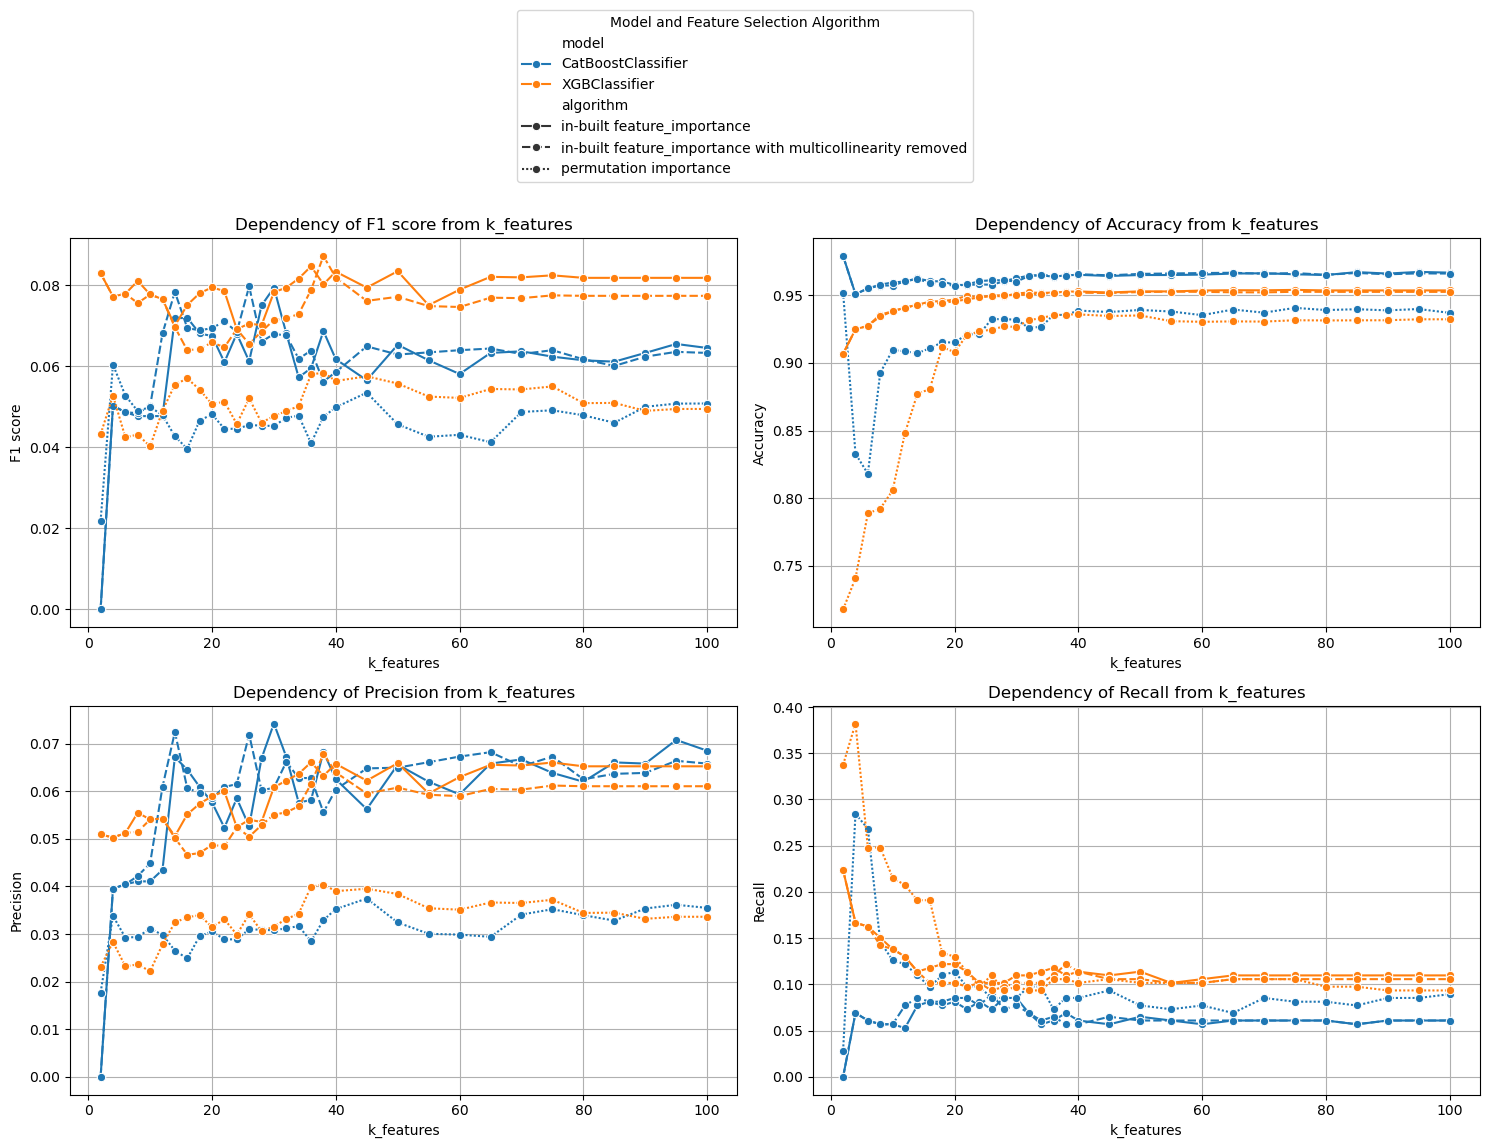

In [44]:
metrics = ["f1", "accuracy", "precision", "recall"]
titles = ["F1 score", "Accuracy", "Precision", "Recall"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(
        data=metrics_k_features, 
        x="k_features", 
        y=metric, 
        hue="model", 
        style="algorithm", 
        marker="o", 
        ax=axes[i])
    
    axes[i].set_title(f"Dependency of {titles[i]} from k_features")
    axes[i].set_xlabel("k_features")
    axes[i].set_ylabel(titles[i])
    axes[i].legend(title="Model and feature selection algorithm", loc="upper left")
    axes[i].grid(True)
    
    # Removing local legends on each plot
    axes[i].legend().remove()

# Adding a common legend
handles, labels = axes[0].get_legend_handles_labels()  # Legend from the 1st plot
fig.legend(handles, labels, title="Model and Feature Selection Algorithm", loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=1)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaving extra space above for the legend
plt.show()


According to the graphs above, in-built feature importance assessment algorithms outperform permutation importance.  
Manual multicollinearity removal slightly worsens results.  

In general, the results are quite poor and metrics are low. 

In most cases, XGBClassifier works better than CatBoostClassifier based on F1-score.  
The best results were obtained with k_features = 38 (multicollinearity removed) and 36 (multicollinearity left).  

I am going to consider 36 features and in-built feature importance algorithm without multicollinearity removal further.

In [45]:
# Parameters for the best F1-score
metrics_k_features[metrics_k_features['f1'] == metrics_k_features['f1'].max()][['model', 'algorithm', 'k_features', 'f1']]

,model,algorithm,k_features,f1
146,XGBClassifier,in-built feature_importance with multicollinea...,38,0.087209


In [46]:
# Parameters for 2nd best F1-score
second_max_f1 = metrics_k_features['f1'].nlargest(2).iloc[-1]
metrics_k_features[metrics_k_features['f1'] == second_max_f1][['model', 'algorithm', 'k_features', 'f1']]

,model,algorithm,k_features,f1
113,XGBClassifier,in-built feature_importance,36,0.084672


In [78]:
# Preparing train, val, test with 36 best features based on in-built feature importance for XGBClassifier
param_dict = {'n_estimators': 500, 
                'max_depth': 3,
                'learning_rate': 0.01,
                'reg_lambda': 4, 
                'objective': 'binary:logistic',  
                'min_child_weight': 3,
                'verbosity': 0}
classifier = 'XGBClassifier'

'''
importance_df = get_permutation_importance(param_dict, 
                                           classifier,
                                           X_train_adasyn,
                                           y_train_adasyn,
                                           X_val_encoded,
                                           y_val)
'''

importance_df = get_feature_importance_xgboost(param_dict, 
                                               X_train_adasyn, 
                                               y_train_adasyn, 
                                               X_val_encoded, 
                                               y_val)

k = 36
X_train_k, y_train_k, X_val_k, y_val_k, X_test_k, y_test_k = select_k_features(importance_df, 
                                                                               k, 
                                                                               X_train = X_train_adasyn, 
                                                                               y_train = y_train_adasyn,
                                                                               X_val = X_val_encoded,
                                                                               y_val = y_val,
                                                                               X_test = X_test_encoded,
                                                                               y_test = y_test)


In [79]:
# Checking shapes
dfs = [X_train_k, y_train_k, X_val_k, y_val_k, X_test_k, y_test_k]
for df_i in dfs:
    print(df_i.shape)

(101956, 36)
(101956,)
(13026, 36)
(13026,)
(34871, 36)
(34871,)


# Grid Search With Cross-Validation

In this section, I am going to work with XGBoost as it performed best previously.  

Let us first find most optimal parameters using GridSearchCV, and then estimate metrics with them.

In [49]:
param_grid = {'n_estimators': [500], 
                'max_depth': [3, 4],
                'learning_rate': [0.01],
                'reg_lambda': [4, 5], 
                'reg_alpha': [0.07, 0.05],
                'subsample': [0.8, 1],   
                'colsample_bytree': [0.8, 0.7],
                'min_child_weight': [3]}

In [50]:
model = xgb.XGBClassifier(objective='binary:logistic', verbosity=0, random_state=42)

grid_search = GridSearchCV(estimator = model, 
                            param_grid = param_grid,  
                            scoring = 'f1',  
                            cv = 5,  
                            verbose = 3,  
                            n_jobs = 4)

grid_search.fit(X_train_k, y_train_k)

print("Best params:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0.07, 'reg_lambda': 5, 'subsample': 1}
Best F1-score: 0.9555207152432533


And of course it returned a very high F1-score.  
This happened because our data was oversampled by ADASYN, that is both train and val subsets contain similar synthetically generated values.  
To avoid it, I need to write my own cross-validation algorithm where oversampling will be applied only to the train part.

In [72]:
# Here are the train, val and test parts before oversampling
print(f"Train: {X_train_encoded.shape}, {y_train.shape}")
print(f"Val: {X_val_encoded.shape}, {y_val.shape}")
print(f"Test: {X_test_encoded.shape}, {y_test.shape}")

Train: (52103, 185), (52103,)
Val: (13026, 184), (13026,)
Test: (34871, 184), (34871,)


In [80]:
# Leaving only 36 most important features as was done previously
X_train_val = pd.concat([X_train_encoded[X_train_k.columns], X_val_encoded[X_train_k.columns]])
y_train_val = pd.concat([y_train, y_val])
print(f"X and y shape: {X_train_val.shape}, {y_train_val.shape}")

X and y shape: (65129, 36), (65129,)


In [53]:
def param_grid_iterator(param_grid=param_grid,
                        j=0, 
                        current_params={},
                        X_train_val=None,
                        y_train_val=None):
    '''
    A function iterating through param_grid for grid search via recursion. 
    It calls train_test_split_cv for each combination of parameters.
    'j' is the number of a current parameter.
    '''
    global metrics_cv
    
    if j == 0:
        current_params = {}
    
    # Iterating through all values of j-parameter and adding them to a dictionary
    for param in param_grid[list(param_grid.keys())[j]]:
        current_params[list(param_grid.keys())[j]] = param

        # Calling the function itself if there are more parameters left
        if j < len(param_grid) - 1:
            param_grid_iterator(param_grid, 
                                j+1, 
                                current_params,
                                X_train_val,
                                y_train_val)

        # If no more parameters left, calling a function for 
        # cross-validation with the current set of parameters
        else:
            print('-' * 20)
            print(f"Params: {current_params}")
            metrics_1cv = train_test_split_cv(current_params,
                                               X_train_val,
                                               y_train_val)
            
            metrics_cv = pd.concat([metrics_cv, metrics_1cv])


In [54]:
def train_test_split_cv(param_dict,
                        X_train_val, 
                        y_train_val):
    '''
    A function that splits the dataset into several parts (cv) for further cross-validation
    and calls fit_predict_val_catboost_xgboost for each part.
    '''
    cv = 5
    # Concating dataframes with X and y, shuffling and separating into two dataframes with different target
    Xy_train_val = pd.concat([X_train_val, y_train_val], axis=1)
    Xy_train_val_1 = Xy_train_val[Xy_train_val['TARGET'] == 1]
    Xy_train_val_0 = Xy_train_val[Xy_train_val['TARGET'] == 0]

    Xy_train_val_1 = Xy_train_val_1.sample(frac = 1, random_state = 42)
    Xy_train_val_0 = Xy_train_val_0.sample(frac = 1, random_state = 42)
    
    Xy_train_val_1.reset_index(drop=True, inplace=True)
    Xy_train_val_0.reset_index(drop=True, inplace=True)

    metrics_1cv = pd.DataFrame()
    print(f"CV fold: ", end = '')
    for i in range(cv):
        print(f"{i+1} ", end = '')
        # Calculating indices
        start_index_1 = len(Xy_train_val_1) // cv * i
        end_index_1 = len(Xy_train_val_1) // cv * (i + 1) - 1

        start_index_0 = len(Xy_train_val_0) // cv * i
        end_index_0 = len(Xy_train_val_0) // cv * (i + 1) - 1     

        # Preparing train part
        Xy_train_1 = Xy_train_val_1.drop(Xy_train_val_1.index[start_index_1:end_index_1])
        Xy_train_0 = Xy_train_val_0.drop(Xy_train_val_0.index[start_index_0:end_index_0])
        Xy_train = pd.concat([Xy_train_1, Xy_train_0])
        Xy_train = Xy_train.sample(frac = 1, random_state = 42)
        X_train = Xy_train.drop(columns = 'TARGET')
        y_train = Xy_train['TARGET']
        
        # Preparing val part
        Xy_val_1 = Xy_train_val_1.loc[start_index_1:end_index_1]
        Xy_val_0 = Xy_train_val_0.loc[start_index_0:end_index_0]
        Xy_val = pd.concat([Xy_val_1, Xy_val_0])
        Xy_val = Xy_val.sample(frac = 1, random_state = 42)
        X_val = Xy_val.drop(columns = 'TARGET')
        y_val = Xy_val['TARGET']

        # Oversampling train part
        asadyn = ADASYN()
        X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

        numerical_features_left = list(set(numerical_features) & set(X_train_adasyn.columns))

        # Scaling train and val parts
        X_train_scaled = X_train_adasyn.copy()
        X_val_scaled = X_val.copy()
        
        scaler = RobustScaler()
        X_train_scaled[numerical_features_left] = scaler.fit_transform(X_train_adasyn[numerical_features_left])
        X_val_scaled[numerical_features_left] = scaler.transform(X_val[numerical_features_left])

        metrics_1cv_1fold = fit_predict_val_catboost_xgboost(param_dict, 
                                                        'XGBClassifier',
                                                        X_train_scaled, 
                                                        y_train_adasyn, 
                                                        X_val_scaled, 
                                                        y_val)
        metrics_1cv_1fold.at[0, 'cv_fold'] = i
        metrics_1cv_1fold.at[0, 'params'] = str(param_dict)
        
        metrics_1cv = pd.concat([metrics_1cv, metrics_1cv_1fold])
    print()
    return metrics_1cv

In [81]:
metrics_cv = pd.DataFrame()

param_grid_iterator(param_grid=param_grid,
                    j=0, 
                    current_params={},
                    X_train_val=X_train_val,
                    y_train_val=y_train_val)

--------------------
Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 4, 'reg_alpha': 0.07, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3}
CV fold: 1 2 3 4 5 
--------------------
Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 4, 'reg_alpha': 0.07, 'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 3}
CV fold: 1 2 3 4 5 
--------------------
Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 4, 'reg_alpha': 0.07, 'subsample': 1, 'colsample_bytree': 0.8, 'min_child_weight': 3}
CV fold: 1 2 3 4 5 
--------------------
Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 4, 'reg_alpha': 0.07, 'subsample': 1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
CV fold: 1 2 3 4 5 
--------------------
Params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 4, 'reg_alpha': 0.05, 'subsample': 0.8, 'colsample_b

In [57]:
metrics_cv.to_csv('metrics_cv.csv', index=False)

In [86]:
metrics_cv = pd.read_csv('metrics_cv.csv')
metrics_cv = metrics_cv.groupby('params', as_index=False).mean()
metrics_cv.drop(columns='cv_fold', inplace=True)
metrics_cv = metrics_cv.sort_values('f1', ascending=False)
metrics_cv[['TN', 'FP', 'FN', 'TP']] = metrics_cv[['TN', 'FP', 'FN', 'TP']].apply(lambda x: round(x)).astype(int)
metrics_cv.head()

,params,accuracy,precision,recall,f1,TN,FP,FN,TP
1,"{'n_estimators': 500, 'max_depth': 3, 'learnin...",0.932653,0.060871,0.178049,0.090698,12104,675,202,44
15,"{'n_estimators': 500, 'max_depth': 3, 'learnin...",0.932745,0.060231,0.175610,0.089646,12106,673,203,43
12,"{'n_estimators': 500, 'max_depth': 3, 'learnin...",0.932868,0.060251,0.175610,0.089634,12107,672,203,43
0,"{'n_estimators': 500, 'max_depth': 3, 'learnin...",0.932530,0.059434,0.173984,0.088506,12103,676,203,43
10,"{'n_estimators': 500, 'max_depth': 3, 'learnin...",0.933344,0.059568,0.170732,0.088222,12115,664,204,42


In [59]:
metrics_cv[metrics_cv['f1'] == metrics_cv['f1'].max()].reset_index(drop=True).loc[0, 'params']

"{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 4, 'reg_alpha': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3}"

Now we can train our final model and estimate metrics on our test, val and train datasets.

# Final Model

In [60]:
best_params = {'n_estimators': 500, 
               'max_depth': 3, 
               'learning_rate': 0.01, 
               'reg_lambda': 4, 
               'reg_alpha': 0.05, 
               'subsample': 0.8, 
               'colsample_bytree': 0.8, 
               'min_child_weight': 3}

In [90]:
# Checking shapes
dfs = [X_train_k, y_train_k, X_val_k, y_val_k, X_test_k, y_test_k]
for df_i in dfs:
    print(df_i.shape)

(101956, 36)
(101956,)
(13026, 36)
(13026,)
(34871, 36)
(34871,)


In [89]:
def train_test_get_metrics(best_params, 
                           X_train_k,
                           y_train_k, 
                           X_val_k, 
                           y_val_k, 
                           X_test_k, 
                           y_test_k):
    '''
    A function that trains XGBClassifier and evaluates its performance on train, val and test subsets.
    '''
    
    model = xgb.XGBClassifier(**best_params, random_state=42)
    model.fit(X_train_k, y_train_k, eval_set=[(X_val_k, y_val_k)], verbose=False)

    metrics = pd.DataFrame()
    datasets = [(X_train_k, y_train_k, 'train'),
                (X_val_k, y_val_k, 'val'),
                (X_test_k, y_test_k, 'test')]
    
    for i, subset in enumerate(datasets):
        
        y_pred = model.predict(subset[0])
        accuracy = accuracy_score(subset[1], y_pred)
        precision = precision_score(subset[1], y_pred)
        recall = recall_score(subset[1], y_pred)
        f1 = f1_score(subset[1], y_pred)
        
        metrics_1 = pd.DataFrame({'accuracy': [accuracy],
                                'precision': [precision],
                                'recall': [recall],
                                'f1': [f1]})
    
        cm = confusion_matrix(subset[1], y_pred)
        metrics_1['TN'] = cm[0, 0]  # True Negatives
        metrics_1['FP'] = cm[0, 1]  # False Positives
        metrics_1['FN'] = cm[1, 0]  # False Negatives
        metrics_1['TP'] = cm[1, 1]  # True Positives
        metrics_1['subset'] = subset[2]
        metrics = pd.concat([metrics, metrics_1])

    # Probablities for visualisations
    y_probs = model.predict_proba(X_test_k)[:, 1]

    # Instantiating SHAP explainer
    explainer = shap.Explainer(model, X_train_k)

    # Calculating SHAP-values
    shap_values = explainer(X_train_k)

    # Mean absolute SHAP-value for each feature
    shap_importance = pd.DataFrame({"Feature": X_train_k.columns,
                                    "SHAP Importance": abs(shap_values.values).mean(axis=0)})
    
    return metrics, y_probs, shap_importance

In [91]:
final_metrics, y_probs, shap_importance = train_test_get_metrics(best_params, 
                                                               X_train_k,
                                                               y_train_k, 
                                                               X_val_k, 
                                                               y_val_k, 
                                                               X_test_k, 
                                                               y_test_k)

100%|===================| 101751/101956 [06:41<00:00]       

In [109]:
final_metrics.to_csv('final_metrics.csv', index=False)
shap_importance.to_csv('shap_importance.csv', index=False)

In [95]:
final_metrics = pd.read_csv('final_metrics.csv')
final_metrics

,accuracy,precision,recall,f1,TN,FP,FN,TP,subset
0,0.944113,0.967423,0.918860,0.942516,49545,1573,4125,46713,train
1,0.950944,0.066225,0.121951,0.085837,12357,423,216,30,val
2,0.975653,0.033645,0.051429,0.040678,34004,517,332,18,test


Expectedly, all metrics on train subset are very high, on val subset they substantially lower, and on test dataset they are the lowest.  
Precision, Recall and F1 are a little above 0.033, 0.051 and 0.040, respectively. It shows us that model performance is too low to utilise it in real-life conditions.

# Visualising Results

In this section I am going to build:
* Confusion matrix
* Roc-auc curve  
* Precision-recall curve  

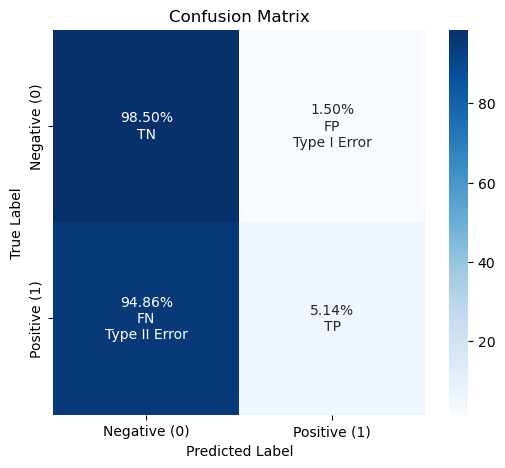

In [66]:
# Plotting confusion matrix 
TN = final_metrics[final_metrics['subset'] == 'test']['TN'].values[0]
TP = final_metrics[final_metrics['subset'] == 'test']['TP'].values[0]
FN = final_metrics[final_metrics['subset'] == 'test']['FN'].values[0]
FP = final_metrics[final_metrics['subset'] == 'test']['FP'].values[0]

def plot_confusion_matrix(TN, FP,
                          FN, TP):
    TPR = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR = FP / (FP + TN)  # False Positive Rate
    FNR = FN / (FN + TP)  # False Negative Rate
    TNR = TN / (TN + FP)  # True Negative Rate (Specificity)
    
    cm = np.array([[TNR, FPR],
                   [FNR, TPR]]) * 100
    
    axis_labels = ['Negative (0)', 'Positive (1)']
    
    labels = np.array([[f"{cm[0, 0]:.2f}%\nTN", f"{cm[0, 1]:.2f}%\nFP\nType I Error"], 
                       [f"{cm[1, 0]:.2f}%\nFN\nType II Error", f"{cm[1, 1]:.2f}%\nTP"]])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(TN, FP,
                      FN, TP)

Based on the confusion matrix built on test subset, our model makes too many FN predictions (type II errors).

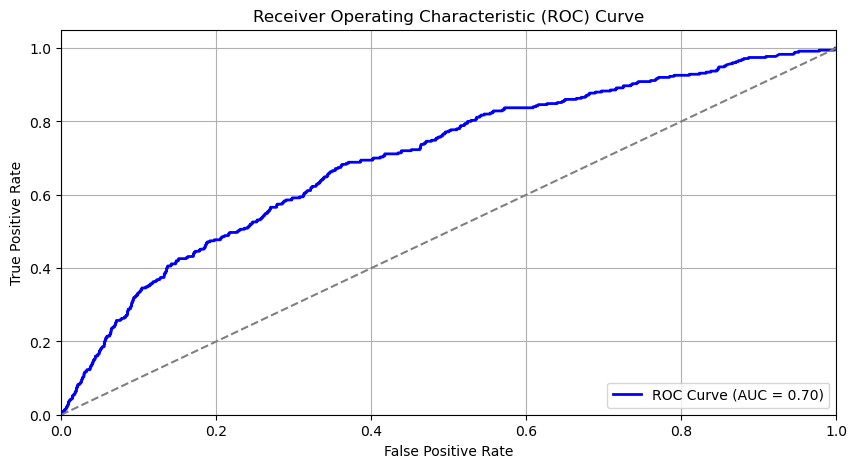

In [67]:
def plot_roc_auc_curve(y_test, y_probs):
    # Computing ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plotting ROC-AUC curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return fpr, tpr

fpr, tpr = plot_roc_auc_curve(y_test_k, y_probs)

AUC = 0.70 means that although Precision, Recall and F1 are very low, our model predictions are better than random labelling.  

Potentiallywe could slightly improve our metrics if we do some of the following:
1. Implement simultaneous cross-validation and feature-selection
2. Try other approaches to feature-selection (for instance, PCA)
3. Thoroughly preprocess data knowing the nature of each feature
4. Try undersampling instead of oversampling
5. Find more optimal parameters that can help cope with overfitting
6. Try other models (logistic regression?)

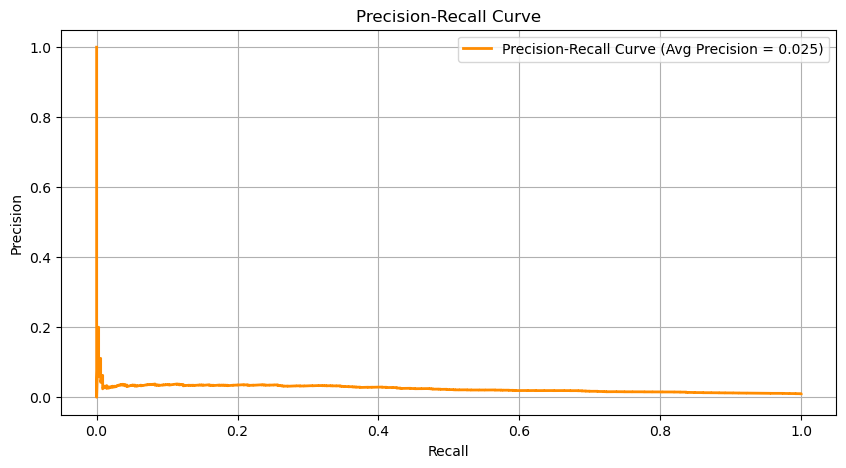

In [69]:
def plot_precision_recall_curve(y_test, y_probs):
    # Computing Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    avg_precision = average_precision_score(y_test, y_probs)
    
    # Plotting Precision-Recall curve
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

plot_precision_recall_curve(y_test_k, y_probs)

The model predicts the positive class very poorly.

# SHAP Importance Analysis

Here are the top-5 important features identified by SHAP.

In [111]:
shap_importance = pd.read_csv('shap_importance.csv')

In [112]:
shap_importance.sort_values('SHAP Importance', ascending=False).head(5)

,Feature,SHAP Importance
0,col_227,0.545047
1,col_205,0.491045
2,col_224,0.206721
3,col_37,0.154206
9,col_122,0.144722
